In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from typing import Tuple

def generate_synthetic_blobs(
    n_samples: int = 3600,
    test_size: int = 600,
    overlap: bool = False,
    ordered: bool = False,
    random_state: int = None
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate a 2D three-class blob dataset, split into train/test, then
    optionally sort the TRAIN set for the 'cf' condition.

    Parameters
    ----------
    n_samples : int
        Total number of samples (train + test).
    test_size : int
        Number of test samples (will be stratified).
    overlap: bool
        Two overlapped clusters if true, separated otherwise
    ordered: bool
        class-ordered if true
    random_state : int, optional
        Seed for reproducibility.

    Returns
    -------
    X_train, y_train, X_test, y_test
    """
    if test_size >= n_samples:
        raise ValueError("test_size must be smaller than n_samples")

    # choose centers/std based on overlap vs. others
    if overlap:
        centers = np.array([[0.0, 0.0],
                            [5.0, 4.2],
                            [4.2, 5.0]])
        cluster_std = [0.5, 0.5, 0.5]
    else:
        centers = np.array([[0.0, 0.0],
                            [5.0, 0.0],
                            [0.0, 5.0]])
        cluster_std = 0.5

    # 1) generate all samples
    X, y = make_blobs(
        n_samples=n_samples,
        centers=centers,
        cluster_std=cluster_std,
        random_state=random_state
    )

    # 2) scale to [0,1]^2
    X_min, X_max = X.min(0), X.max(0)
    X = (X - X_min) / (X_max - X_min)

    # 3) train-test split (stratified & randomized)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )

    # 4) if CF scenario, sort train by class label
    if ordered:
        order = np.argsort(y_train)
        X_train, y_train = X_train[order], y_train[order]

    return X_train, y_train, X_test, y_test


In [3]:
import matplotlib.pyplot as plt
from typing import Optional
import numpy as np

def plot_synthetic_blobs(
    X: np.ndarray,
    y: np.ndarray,
    ax: Optional[plt.Axes] = None,
    title: Optional[str] = None,
    marker: str = "o",
    alpha: float = 0.8,
) -> plt.Axes:
    """
    Scatter‐plot a 2D three‐class blob dataset.

    Parameters
    ----------
    X : array of shape (n_samples, 2)
        2D feature matrix.
    y : array of shape (n_samples,)
        Integer class labels (0, 1, 2).
    ax : matplotlib.axes.Axes, optional
        If provided, plot onto this Axes; otherwise a new figure & axes are created.
    title : str, optional
        Title for the plot.
    marker : str
        Marker style for the scatter.
    alpha : float
        Alpha transparency for the points.

    Returns
    -------
    ax : matplotlib.axes.Axes
        The axes with the scatter on it.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    # choose a discrete colormap
    cmap = plt.get_cmap("tab10")
    classes = np.unique(y)
    for cls in classes:
        mask = (y == cls)
        ax.scatter(
            X[mask, 0],
            X[mask, 1],
            marker=marker,
            alpha=alpha,
            label=f"Class {cls}",
            color=cmap(int(cls)),
        )

    ax.legend(title="Class")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    if title:
        ax.set_title(title)
    ax.set_aspect("equal", "box")
    ax.grid(True, linestyle="--", alpha=0.5)
    return ax


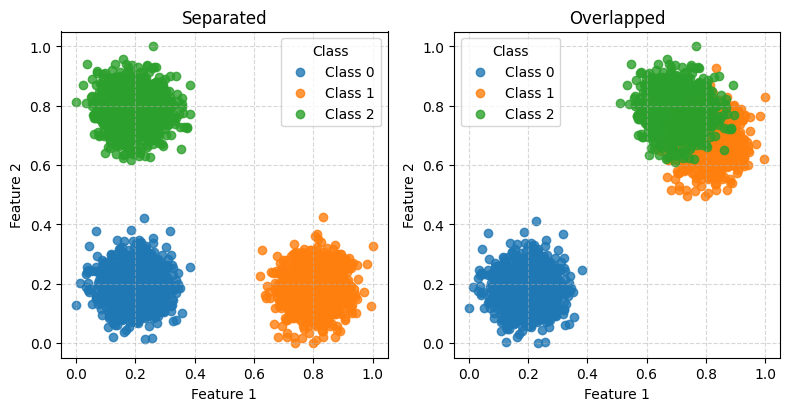

In [4]:
import matplotlib.pyplot as plt

# generate data
X_cf, y_cf, _, _     = generate_synthetic_blobs(3600, 600, overlap=False, ordered=True, random_state=42)
X_ov, y_ov, _, _     = generate_synthetic_blobs(3600, 600, overlap=True, ordered=False, random_state=42)
# X_good, y_good, _, _ = generate_synthetic_blobs(3600, 600, overlap=False, ordered=False,    random_state=42)
# X_ovcf, y_ovcf, _, _ = generate_synthetic_blobs(3600, 600, overlap=True, ordered=True,    random_state=42)

# plot each
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# plot_synthetic_blobs(X_cf, y_cf, ax=axes[0], title="Separated, ordered")
# plot_synthetic_blobs(X_ov, y_ov, ax=axes[1], title="Overlapped, Shuffled")
# plot_synthetic_blobs(X_good, y_good, ax=axes[2], title="Separated, Shuffled")
# plot_synthetic_blobs(X_ovcf, y_ovcf, ax=axes[3], title="Overlapped, Ordered")
fig, axes = plt.subplots(1, 2, figsize=(8, 5))
plot_synthetic_blobs(X_cf, y_cf, ax=axes[0], title="Separated")
plot_synthetic_blobs(X_ov, y_ov, ax=axes[1], title="Overlapped")
plt.tight_layout()
plt.savefig("figures/condition_blobs.png")
plt.show()


In [8]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from typing import List, Tuple, Dict

from OverlapIndex import OverlapIndex
from OCF import OCF


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()


def build_mlp(input_dim: int = 2, n_classes: int = 3) -> keras.Model:
    init = keras.initializers.GlorotUniform(seed=SEED)
    inp = keras.Input(shape=(input_dim,))
    x   = keras.layers.Dense(16, activation="relu", kernel_initializer=init)(inp)
    x   = keras.layers.Dense(16, activation="relu", kernel_initializer=init)(x)
    out = keras.layers.Dense(n_classes, activation="softmax", kernel_initializer=init)(x)
    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-2),
        # optimizer=keras.optimizers.SGD(learning_rate=1e-1),
        loss="sparse_categorical_crossentropy",
        metrics=[]
    )
    return model


from OCF import OCF

def run_condition(
    X_train: np.ndarray, y_train: np.ndarray,
    X_test:  np.ndarray, y_test:  np.ndarray,
    batch_size: int = 50,
    rho: float = 0.9,
    r_hat: float = 0.1,
    ART: str   = "Fuzzy"
) -> Tuple[List[List[float]], List[float], List[str]]:
    """
    Train one epoch in exact order. Returns:
      - tpr_trace:       List of [tpr_class0, tpr_class1, tpr_class2] per batch
      - oi_trace:     List of oi_index per batch (training data)
      - cf_state_trace:  List of OCF states per batch (based on test predictions)
    """
    # Prepare dataset
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
                 .batch(batch_size, drop_remainder=True)

    x_test_batch = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_test_batch = tf.convert_to_tensor(y_test, dtype=tf.int32)

    # Initialize model and tracking tools
    model = build_mlp(input_dim=2, n_classes=3)
    oi_obj = OverlapIndex(rho=rho, r_hat=r_hat, ART=ART)
    cf_detector = OCF(oi_thresh=0.9, acc_drop_thresh=0.3, rho=rho, r_hat=r_hat, ART=ART)

    # Traces to record
    tpr_trace:      List[List[float]] = []
    oi_trace:    List[float]       = []
    cf_state_trace: List[str]         = []

    for x_b, y_b in train_ds:
        # Step 1: Train on batch
        model.train_on_batch(x_b, y_b)

        # Step 2: Evaluate on entire test set
        probs = model.predict(x_test_batch, batch_size=y_test_batch.shape[0], verbose=0)
        y_pred = np.argmax(probs, axis=1)

        # Step 3: Compute per-class TPR
        tprs = []
        for cls in range(3):
            mask = (y_test_batch.numpy() == cls)
            tp   = np.sum(y_pred[mask] == cls)
            fn   = np.sum(y_pred[mask] != cls)
            tprs.append(tp / (tp + fn) if (tp + fn) > 0 else 0.0)
        tpr_trace.append(tprs)

        

        # Step 4: Update OCF using training + test signals
        state = cf_detector.add_batch(
            X_train=x_b.numpy(),
            y_train=y_b.numpy(),
            y_pred_eval=y_pred,
            y_true_eval=y_test
        )
        cf_state_trace.append(list(state))

        # Step 5: Record OverlapIndex oi index from *training* batch
        idx = cf_detector.iInter.index
        oi_trace.append(idx)

    return tpr_trace, oi_trace, cf_state_trace




import json

if __name__ == "__main__":
    traces_tpr:   Dict[str, List[List[float]]] = {}
    traces_oi: Dict[str, List[float]]       = {}
    traces_state: Dict[str, List[str]]         = {}

    for ov, od in ((False, False), (False, True), (True, False), (True, True)):
        X_tr, y_tr, X_te, y_te = generate_synthetic_blobs(
            n_samples=3600,
            test_size=600,
            overlap=ov,
            ordered=od,
            random_state=SEED
        )
        cond = ("Overlapped, " if ov else "Separated, ") + ("Ordered" if od else "Shuffled")
        print(f"→ running condition {cond}")
        tpr, oi_idx, states = run_condition(
            X_tr, y_tr, X_te, y_te,
            batch_size=20,
            rho=0.95,
            r_hat=0.1,
            ART="Fuzzy"
        )
        traces_tpr[cond]   = tpr
        traces_oi[cond] = oi_idx
        traces_state[cond] = states

    # Save TPR and OverlapIndex arrays
    np.savez("batch_traces.npz",
             ov_od_tpr =   traces_tpr["Overlapped, Ordered"],
             ov_sh_tpr =   traces_tpr["Overlapped, Shuffled"],
             sp_sh_tpr =   traces_tpr["Separated, Shuffled"],
             sp_od_tpr =   traces_tpr["Separated, Ordered"],
             ov_od_int =   traces_oi["Overlapped, Ordered"],
             ov_sh_int =   traces_oi["Overlapped, Shuffled"],
             sp_od_int =   traces_oi["Separated, Ordered"],
             sp_sh_int =   traces_oi["Separated, Shuffled"],
            )

    # Save OCF states (strings) separately
    with open("cf_states.json", "w") as f:
        json.dump(traces_state, f, indent=2)

    print("Saved per-batch TPR and OverlapIndex indices to batch_traces.npz")
    print("Saved OCF states to cf_states.json")



→ running condition Separated, Shuffled
→ running condition Separated, Ordered
→ running condition Overlapped, Shuffled
→ running condition Overlapped, Ordered
Saved per-batch TPR and OverlapIndex indices to batch_traces.npz
Saved OCF states to cf_states.json


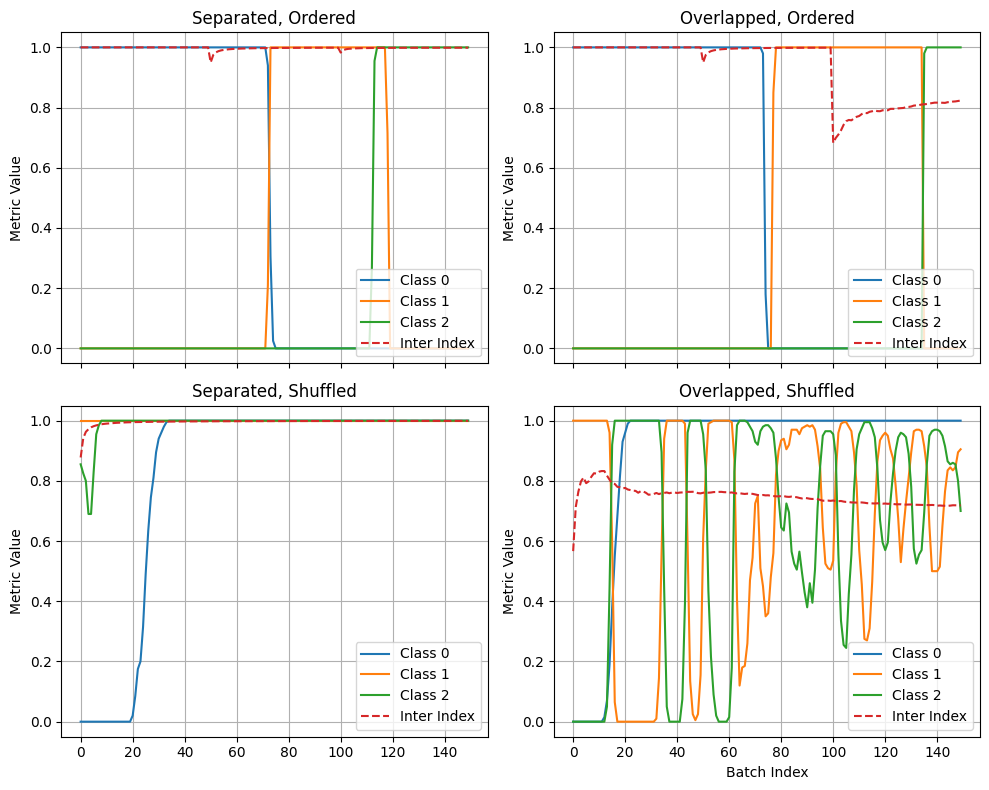

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Load the combined TPR + oi traces
data = np.load('batch_traces.npz', allow_pickle=True)

conditions = ['Separated, Ordered', 'Overlapped, Ordered', 'Separated, Shuffled', "Overlapped, Shuffled"]
class_labels = ['Class 0', 'Class 1', 'Class 2']

# mapping from condition → key prefix in the .npz
prefix = {'Separated':'sp', 'Overlapped':'ov', 'Ordered':'od', 'Shuffled': 'sh'}

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)

# Flatten the 2D axes array to a 1D iterator
axes = axes.flatten()

for ax, cond in zip(axes, conditions):
    p1, p2 = cond.split(", ")
    p = prefix[p1]+"_"+prefix[p2]
    tpr   = data[f'{p}_tpr']   # shape (n_batches, 3)
    oi = data[f'{p}_int']   # shape (n_batches,)

    # plot per‐class TPRs
    for i, cls_label in enumerate(class_labels):
        ax.plot(tpr[:, i], label=cls_label)
    # plot the oi‐index
    ax.plot(oi, label='Inter Index', linestyle='--')

    ax.set_title(cond)
    ax.set_ylabel('Metric Value')
    ax.grid(True)
    ax.legend(loc='lower right')

axes[-1].set_xlabel('Batch Index')
plt.tight_layout()
plt.savefig("figures/overlap_index_blobs_w_accuracy.png")
plt.show()


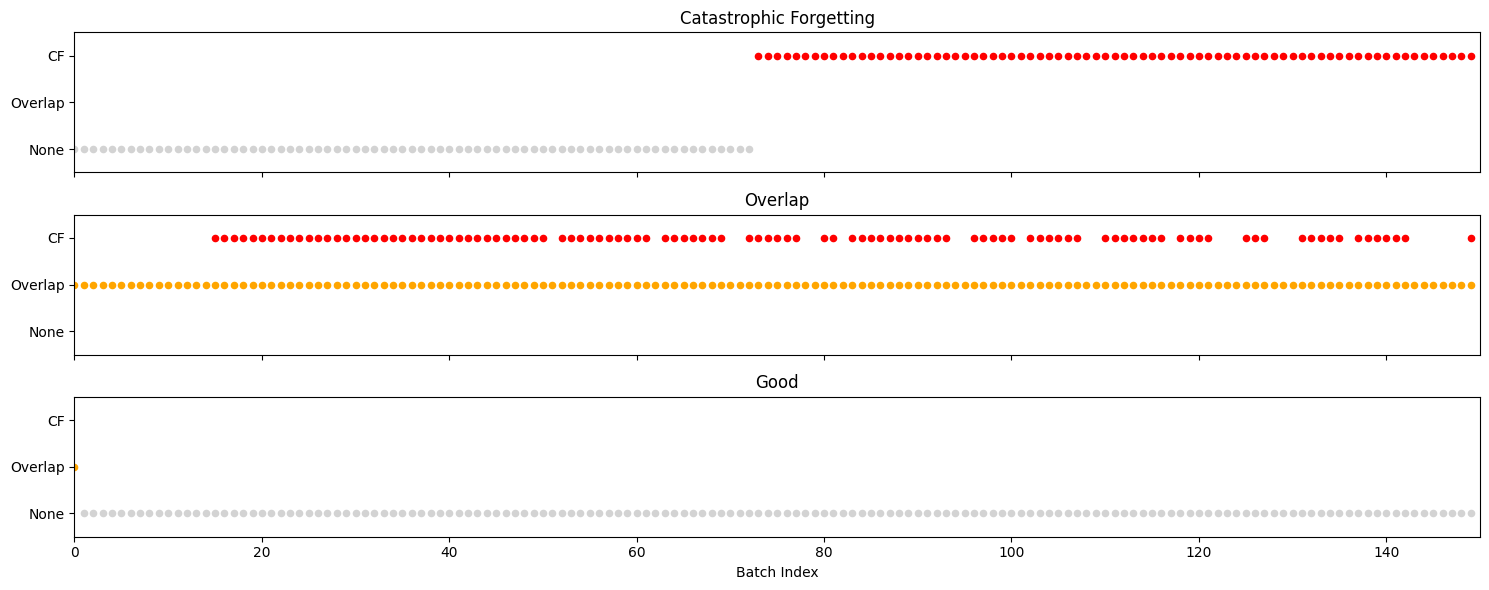

In [6]:
import matplotlib.pyplot as plt

# Replace with your actual data
data = traces_state

keys = ['cf', 'overlap', 'good']
state_order = ['None', 'Overlap', 'CF']
y_map = {
    'overlap': 1,
    'cf': 2
}
colors = {
    'cf': 'red',
    'overlap': 'orange',
    'none': 'lightgray'
}

timesteps = len(data['cf'])
fig, axes = plt.subplots(nrows=3, figsize=(15, 6), sharex=True, sharey=True)

for ax, key in zip(axes, keys):
    x_cf, y_cf = [], []
    x_ol, y_ol = [], []

    for t, state in enumerate(data[key]):
        states = [s.lower() for s in state]

        if 'cf' in states:
            x_cf.append(t)
            y_cf.append(y_map['cf'])

        if 'overlap' in states:
            x_ol.append(t)
            y_ol.append(y_map['overlap'])

    # Plot both markers per trace
    ax.scatter(x_ol, y_ol, color=colors['overlap'], label='Overlap', s=20)
    ax.scatter(x_cf, y_cf, color=colors['cf'], label='CF', s=20)

    # If neither present, optionally show a gray dot (or skip)
    y_none = []
    x_none = []
    for t in range(timesteps):
        states = [s.lower() for s in data[key][t]]
        if 'cf' not in states and 'overlap' not in states:
            x_none.append(t)
            y_none.append(0)
    ax.scatter(x_none, y_none, color=colors['none'], label='None', s=20)

    # Axes formatting
    ax.set_title(key.replace("cf", "Catastrophic Forgetting").title())
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(state_order)
    ax.set_xlim(0, timesteps)
    ax.set_ylim(-0.5, 2.5)

axes[-1].set_xlabel("Batch Index")
plt.tight_layout()
plt.savefig("figures/OCF_metric_timeseries.png")
plt.show()



In [7]:
from artlib import FusionART, FuzzyART
import numpy as np
import matplotlib.pyplot as plt
from OverlapIndex import OverlapIndex
from tqdm.notebook import tqdm

def func(n_samples, freq):
    x = np.linspace(0, np.pi, n_samples)
    y = np.sin(freq*x)
    return x.reshape((-1,1)), y.reshape((-1,1))


RHO = 0.95
ALPHA = 1e-10
BETA = 1.0
FREQ_MIN = 0.
FREQ_MAX = 10
NSAMPLES = 1000

FREQS = np.linspace(FREQ_MIN, FREQ_MAX, 30)

index_values = []

for freq in tqdm(FREQS):
    x, y = func(NSAMPLES, freq)

    art_a = FuzzyART(0.0, ALPHA, BETA)
    art_b = FuzzyART(RHO, ALPHA, BETA)
    cls = FusionART([art_a, art_b], gamma_values= [0.5, 0.5], channel_dims=[2,2])
    x_prep = art_a.prepare_data(x)
    y_prep = art_b.prepare_data(y)
    X = cls.join_channel_data(channel_data=[x_prep, y_prep])
    labels = cls.fit_predict(X)

    oi = OverlapIndex(rho=1.0, r_hat=np.inf, ART="Fuzzy")
    index = oi.add_batch(x_prep, labels)
    index_values.append(index)

with open("sin_oi.json", "w") as f:
        json.dump(index_values, f, indent=2)

  0%|          | 0/30 [00:00<?, ?it/s]

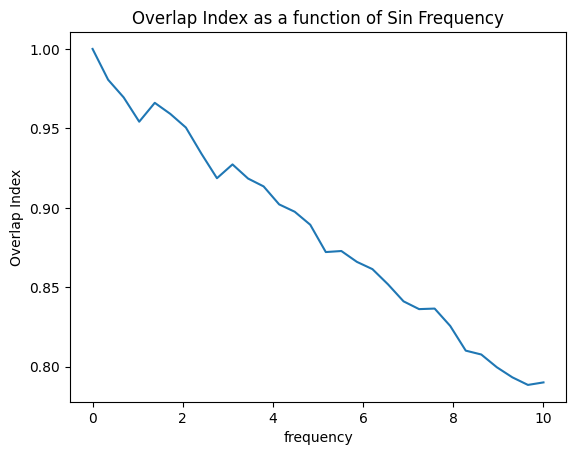

In [8]:
plt.figure()
plt.plot(FREQS, index_values)
plt.title("Overlap Index as a function of Sin Frequency")
plt.xlabel("frequency")
plt.ylabel("Overlap Index")
plt.savefig("figures/overlap_vs_sin_freq.png")

/Users/niklasmelton/Library/Python/3.9/lib/python/site-packages/artlib/common/BaseART.py:955: UserWarning: FusionART does not support plotting cluster bounds.
  warn(f"{self.__class__.__name__} does not support plotting cluster bounds.")


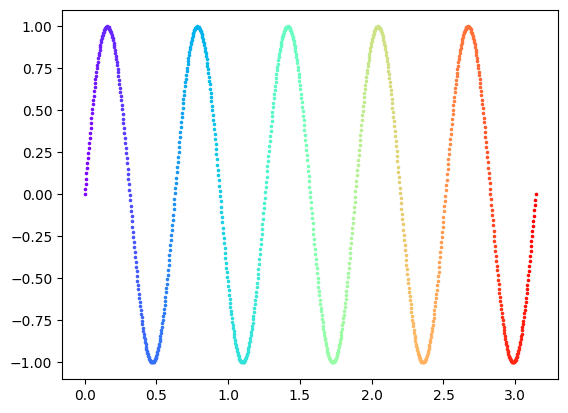

In [9]:
cls.visualize(np.concatenate([x,y],axis=1), labels)

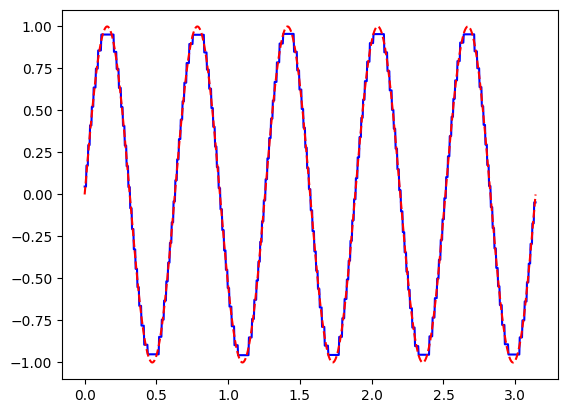

In [10]:
x, y = func(1000, 10)
RHO = 0.95
art_a = FuzzyART(0.0, ALPHA, BETA)
art_b = FuzzyART(RHO, ALPHA, BETA)
cls = FusionART([art_a, art_b], gamma_values= [0.5, 0.5], channel_dims=[2,2])
x_prep = art_a.prepare_data(x)
y_prep = art_b.prepare_data(y)
X = cls.join_channel_data(channel_data=[x_prep, y_prep])
labels = cls.fit_predict(X)

X_no_y = cls.join_channel_data(channel_data=[x_prep], skip_channels=[-1])
y_pred = cls.predict_regression(X_no_y, target_channels=[-1])
fig = plt.figure()
plt.plot(x, y_pred, "b-")
plt.plot(x, y, "r--")
plt.show()

0.7901694677871148


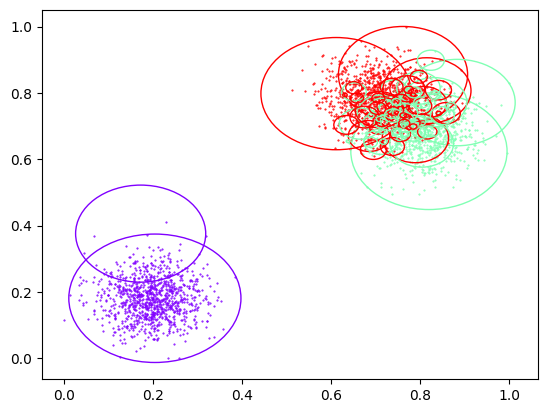

In [11]:
oi = OverlapIndex(0.8, r_hat=1.0, ART="Hypersphere")
print(index)
index = oi.add_batch(X_ov, y_ov)
oi.ARTMAP.visualize(X_ov, y_ov, marker_size=1)

In [14]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from typing import List, Tuple, Dict

from OverlapIndex import OverlapIndex
from OCF import OCF2

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()


def build_mlp(input_dim: int = 2, n_classes: int = 3
              ) -> Tuple[keras.Model, keras.Model]:
    init = keras.initializers.GlorotUniform(seed=SEED)
    inp = keras.Input(shape=(input_dim,), name="input")
    x   = keras.layers.Dense(16, activation="relu",  kernel_initializer=init, name="dense1")(inp)
    x   = keras.layers.Dense(16, activation="relu",  kernel_initializer=init, name="dense2")(x)
    logits = keras.layers.Dense(n_classes, activation=None, kernel_initializer=init, name="logits")(x)
    probs  = keras.layers.Activation("softmax", name="softmax")(logits)

    train_model = keras.Model(inp, probs, name="classifier")
    logit_model = keras.Model(inp, logits, name="logit_extractor")

    train_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-2),
        loss="sparse_categorical_crossentropy",
        metrics=[]
    )
    return train_model, logit_model


def run_condition(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test:  np.ndarray,
    y_test:  np.ndarray,
    batch_size: int = 50,
    rho: float = 0.9,
    r_hat: float = 0.1,
    ART: str   = "Fuzzy"
) -> Tuple[
    List[List[float]],
    List[float],
    List[Tuple[float, float]]
]:
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
                 .batch(batch_size, drop_remainder=True)

    x_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.int32)

    model, logit_extractor = build_mlp(X_train.shape[1], int(np.max(y_train)) + 1)
    cf_detector = OCF2(rho=rho, r_hat=r_hat, ART=ART)
    cf_detector.OI.ARTMAP.module_a.set_data_bounds(np.zeros((2,)), np.ones((2,)))

    tpr_trace: List[List[float]] = []
    oi_trace:  List[float] = []
    ocf_trace: List[Tuple[float, float]] = []

    for x_b, y_b in train_ds:
        model.train_on_batch(x_b, y_b)

        logits = logit_extractor.predict(x_test_tf, batch_size=y_test_tf.shape[0], verbose=0)
        probs  = model.predict(x_test_tf, batch_size=y_test_tf.shape[0], verbose=0)
        y_pred = np.argmax(probs, axis=1)

        tprs = []
        for cls in range(probs.shape[1]):
            mask = (y_test_tf.numpy() == cls)
            tp   = np.sum(y_pred[mask] == cls)
            fn   = np.sum(y_pred[mask] != cls)
            tprs.append(tp / (tp + fn) if (tp + fn) > 0 else 0.0)
        tpr_trace.append(tprs)

        x_b_prep = cf_detector.OI.ARTMAP.module_a.prepare_data(x_b.numpy())
        O, F = cf_detector.add_batch(
            X_train       = x_b_prep,
            y_train       = y_b.numpy(),
            y_pred_eval   = y_pred,
            y_true_eval   = y_test,
            y_scores_eval = logits
        )
        ocf_trace.append((O, F))
        oi_trace.append(cf_detector.OI.index)

    return tpr_trace, oi_trace, ocf_trace


if __name__ == "__main__":
    traces_tpr:   Dict[str, List[List[float]]]         = {}
    traces_oi:    Dict[str, List[float]]               = {}
    traces_state: Dict[str, List[Tuple[float, float]]] = {}

    for ov, od in ((False, False), (False, True), (True, False), (True, True)):
        X_tr, y_tr, X_te, y_te = generate_synthetic_blobs(
            n_samples=3600,
            test_size=600,
            overlap=ov,
            ordered=od,
            random_state=SEED
        )
        cond = ("Overlapped, " if ov else "Separated, ") + ("Ordered" if od else "Shuffled")
        print(f"→ running condition {cond}")
        tpr, oi_idx, ocf_states = run_condition(
            X_tr, y_tr, X_te, y_te,
            batch_size=20,
            rho=0.95,
            r_hat=0.1,
            ART="Fuzzy"
        )
        traces_tpr[cond]   = tpr
        traces_oi[cond]    = oi_idx
        traces_state[cond] = ocf_states

    # Save as structured arrays for traceability
    np.savez(
        "cf2_batch_traces.npz",
        ov_od_tpr = traces_tpr["Overlapped, Ordered"],
        ov_sh_tpr = traces_tpr["Overlapped, Shuffled"],
        sp_od_tpr = traces_tpr["Separated, Ordered"],
        sp_sh_tpr = traces_tpr["Separated, Shuffled"],
        ov_od_int = traces_oi["Overlapped, Ordered"],
        ov_sh_int = traces_oi["Overlapped, Shuffled"],
        sp_od_int = traces_oi["Separated, Ordered"],
        sp_sh_int = traces_oi["Separated, Shuffled"],
        ov_od_states = np.array(traces_state["Overlapped, Ordered"]),
        ov_sh_states = np.array(traces_state["Overlapped, Shuffled"]),
        sp_od_states = np.array(traces_state["Separated, Ordered"]),
        sp_sh_states = np.array(traces_state["Separated, Shuffled"]),
    )

    print("Saved per-batch TPR, OverlapIndex, and OCF2 states to cf2_batch_traces.npz")


→ running condition Separated, Shuffled
→ running condition Separated, Ordered
→ running condition Overlapped, Shuffled
→ running condition Overlapped, Ordered
Saved per-batch TPR, OverlapIndex, and OCF2 states to cf2_batch_traces.npz


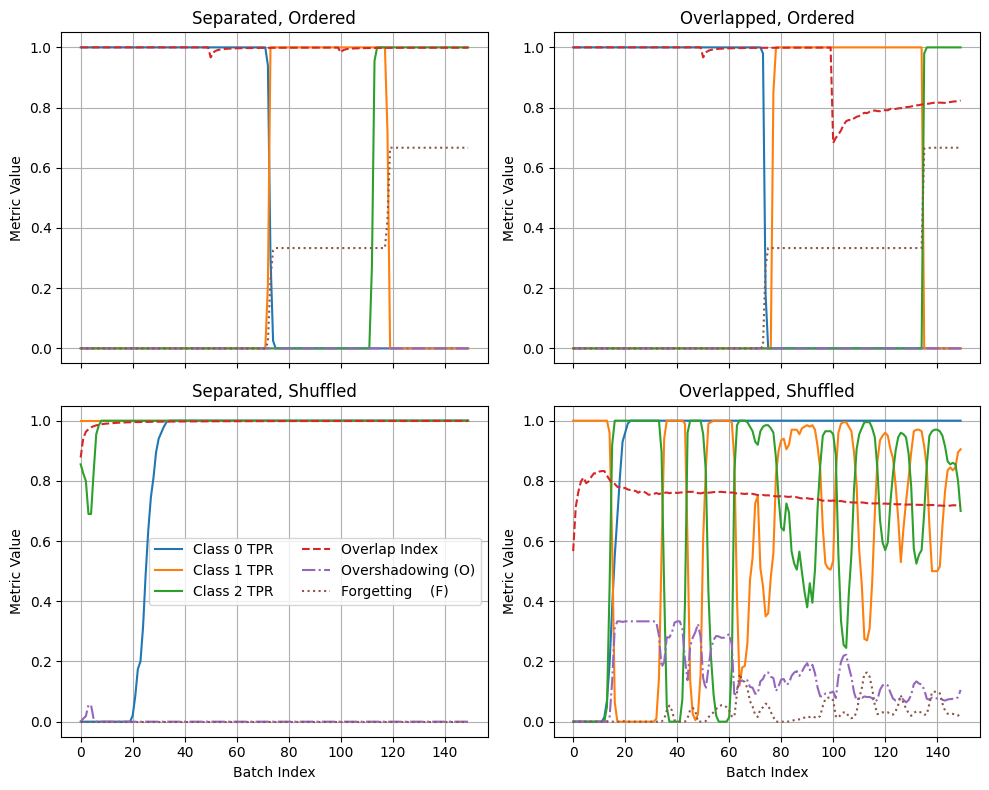

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# 1) load your TPR, overlap‐index, and OCF2 states from the .npz
data = np.load('cf2_batch_traces.npz')

conditions = ['Separated, Ordered', 'Overlapped, Ordered', 'Separated, Shuffled', "Overlapped, Shuffled"]
class_labels = ['Class 0', 'Class 1', 'Class 2']

# mapping from condition → key prefix in the .npz
prefix = {'Separated':'sp', 'Overlapped':'ov', 'Ordered':'od', 'Shuffled': 'sh'}

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)

# Flatten the 2D axes array to a 1D iterator
axes = axes.flatten()

for ax, cond in zip(axes, conditions):
    p1, p2 = cond.split(", ")
    p = prefix[p1]+"_"+prefix[p2]
    tpr  = data[f'{p}_tpr']    # shape (n_batches, 3)
    oi   = data[f'{p}_int']    # shape (n_batches,)
    ofr  = data[f'{p}_states'] # shape (n_batches, 2): [O, F]

    O, F = ofr[:, 0], ofr[:, 1]

    # plot per‐class TPR
    for i, lbl in enumerate(class_labels):
        ax.plot(tpr[:, i], label=lbl+" TPR")

    # plot the overlap‐index
    ax.plot(oi, label='Overlap Index', linestyle='--')

    # plot O & F
    ax.plot(O, label='Overshadowing (O)', linestyle='-.')
    ax.plot(F, label='Forgetting    (F)', linestyle=':')

    ax.set_title(cond)
    ax.set_ylabel('Metric Value')
    ax.grid(True)

axes[2].legend(loc='center right', ncols=2)
axes[2].set_xlabel('Batch Index')
axes[3].set_xlabel('Batch Index')
plt.tight_layout()
plt.savefig("figures/overlap_index_blobs_w_accuracy_and_ocf2.png")
plt.show()


In [18]:
import random
import numpy as np
from typing import List, Tuple, Dict

from ActivationKNN import KNN
from OverlapIndex import OverlapIndex
from OCF import OCF2

SEED = 42
random.seed(SEED)
np.random.seed(SEED)


def run_condition(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test:  np.ndarray,
    y_test:  np.ndarray,
    batch_size: int = 50,
    rho: float = 0.9,
    r_hat: float = 0.1,
    ART: str   = "Fuzzy",
    knn_kwargs: dict = None
) -> Tuple[
    List[List[float]],         # tpr_trace
    List[float],               # oi_trace
    List[Tuple[float, float]], # global ocf_trace
    List[List[float]],         # per-cluster forgetting
    List[List[float]]          # per-cluster overshadowing
]:
    if knn_kwargs is None:
        knn_kwargs = {"n_neighbors": 1}

    n_true = int(np.max(y_train)) + 1
    X_mem: List[np.ndarray] = []
    y_mem: List[np.ndarray] = []

    knn = KNN(**knn_kwargs)
    cf_detector = OCF2(rho=rho, r_hat=r_hat, ART=ART)
    cf_detector.OI.ARTMAP.module_a.set_data_bounds(
        np.zeros((X_train.shape[1],)), 
        np.ones((X_train.shape[1],))
    )

    tpr_trace: List[List[float]] = []
    oi_trace: List[float] = []
    ocf_trace: List[Tuple[float, float]] = []
    cluster_forgetting_trace: List[List[float]] = []
    cluster_overshadowing_trace: List[List[float]] = []

    n_batches = len(y_train) // batch_size
    for i in range(n_batches):
        x_b = X_train[i*batch_size:(i+1)*batch_size]
        y_b = y_train[i*batch_size:(i+1)*batch_size]

        # 1) update memory and refit KNN
        X_mem.append(x_b)
        y_mem.append(y_b)
        X_seen = np.vstack(X_mem)
        y_seen = np.concatenate(y_mem)
        knn.fit(X_seen, y_seen)

        # 2) activations and predictions
        scores = knn.activation(X_test)
        y_pred = knn.predict(X_test)

        # 3) TPR per class
        tprs = []
        for cls in range(n_true):
            mask = (y_test == cls)
            tp = np.sum(y_pred[mask] == cls)
            fn = np.sum(y_pred[mask] != cls)
            tprs.append(tp/(tp+fn) if (tp+fn) > 0 else 0.0)
        tpr_trace.append(tprs)

        # 4) global OCF2 update
        x_b_prep = cf_detector.OI.ARTMAP.module_a.prepare_data(x_b)
        O, F = cf_detector.add_batch(
            X_train       = x_b_prep,
            y_train       = y_b,
            y_pred_eval   = y_pred,
            y_true_eval   = y_test,
            y_scores_eval = scores
        )
        ocf_trace.append((O, F))

        # 5) Overlap Index
        oi_trace.append(cf_detector.OI.index)

        # 6) Per-cluster O and F (padded)
        forgetting_row = []
        overshadowing_row = []
        for cls in range(n_true):
            st = cf_detector.cluster_indices.get(cls, {})
            forgetting_row.append(st.get("forgetting", 0.0))
            overshadowing_row.append(st.get("overshadowing", 0.0))
        cluster_forgetting_trace.append(forgetting_row)
        cluster_overshadowing_trace.append(overshadowing_row)

    return (
        tpr_trace,
        oi_trace,
        ocf_trace,
        cluster_forgetting_trace,
        cluster_overshadowing_trace
    )


if __name__ == "__main__":
    traces_tpr:   Dict[str, np.ndarray] = {}
    traces_oi:    Dict[str, np.ndarray] = {}
    traces_state: Dict[str, np.ndarray] = {}
    traces_forg:  Dict[str, np.ndarray] = {}
    traces_over:  Dict[str, np.ndarray] = {}

    for ov, od in ((False, False), (False, True), (True, False), (True, True)):
        X_tr, y_tr, X_te, y_te = generate_synthetic_blobs(
            n_samples=3600,
            test_size=600,
            overlap=ov,
            ordered=od,
            random_state=SEED
        )
        cond = ("Overlapped, " if ov else "Separated, ") + ("Ordered" if od else "Shuffled")
        print(f"→ running condition {cond}")

        (tpr, oi_idx, ocf_states,
         cluster_f, cluster_o) = run_condition(
            X_tr, y_tr, X_te, y_te,
            batch_size=20,
            rho=0.95,
            r_hat=0.1,
            ART="Fuzzy",
            knn_kwargs={"n_neighbors": 1}
        )

        traces_tpr[cond]   = np.array(tpr, dtype=float)
        traces_oi[cond]    = np.array(oi_idx, dtype=float)
        traces_state[cond] = np.array(ocf_states, dtype=float)
        traces_forg[cond]  = np.array(cluster_f, dtype=float)
        traces_over[cond]  = np.array(cluster_o, dtype=float)

    np.savez(
        "cf2_batch_traces_knn_with_clusters.npz",
        ov_od_tpr = traces_tpr["Overlapped, Ordered"],
        ov_sh_tpr = traces_tpr["Overlapped, Shuffled"],
        sp_od_tpr = traces_tpr["Separated, Ordered"],
        sp_sh_tpr = traces_tpr["Separated, Shuffled"],
        ov_od_int = traces_oi["Overlapped, Ordered"],
        ov_sh_int = traces_oi["Overlapped, Shuffled"],
        sp_od_int = traces_oi["Separated, Ordered"],
        sp_sh_int = traces_oi["Separated, Shuffled"],
        ov_od_states = traces_state["Overlapped, Ordered"],
        ov_sh_states = traces_state["Overlapped, Shuffled"],
        sp_od_states = traces_state["Separated, Ordered"],
        sp_sh_states = traces_state["Separated, Shuffled"],
        ov_od_forg = traces_forg["Overlapped, Ordered"],
        ov_sh_forg = traces_forg["Overlapped, Shuffled"],
        sp_od_forg = traces_forg["Separated, Ordered"],
        sp_sh_forg = traces_forg["Separated, Shuffled"],
        ov_od_over = traces_over["Overlapped, Ordered"],
        ov_sh_over = traces_over["Overlapped, Shuffled"],
        sp_od_over = traces_over["Separated, Ordered"],
        sp_sh_over = traces_over["Separated, Shuffled"],
    )

    print("Saved KNN-based OCF2 traces with per-cluster and global metrics.")


→ running condition Separated, Shuffled
→ running condition Separated, Ordered
→ running condition Overlapped, Shuffled
→ running condition Overlapped, Ordered
Saved KNN-based OCF2 traces with per-cluster and global metrics.


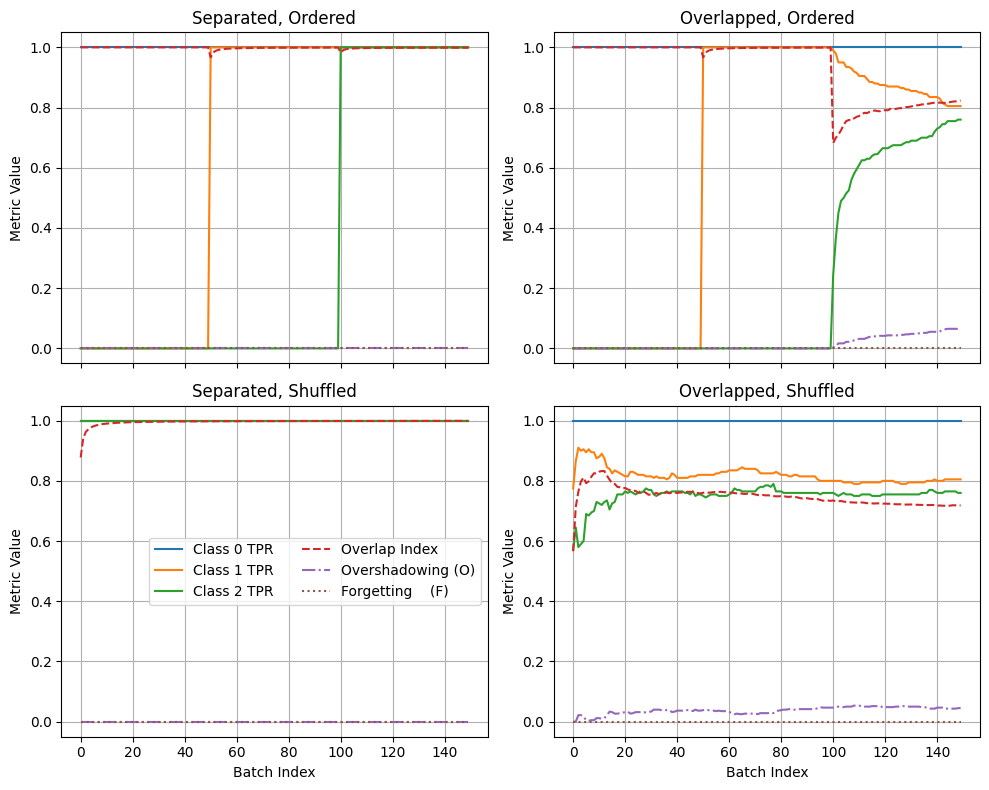

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# 1) load your TPR, overlap‐index, and OCF2 states from the .npz
data = np.load('cf2_batch_traces_knn_with_clusters.npz')

conditions = ['Separated, Ordered', 'Overlapped, Ordered', 'Separated, Shuffled', "Overlapped, Shuffled"]
class_labels = ['Class 0', 'Class 1', 'Class 2']

# mapping from condition → key prefix in the .npz
prefix = {'Separated':'sp', 'Overlapped':'ov', 'Ordered':'od', 'Shuffled': 'sh'}

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)

# Flatten the 2D axes array to a 1D iterator
axes = axes.flatten()

for ax, cond in zip(axes, conditions):
    p1, p2 = cond.split(", ")
    p = prefix[p1]+"_"+prefix[p2]
    tpr  = data[f'{p}_tpr']    # shape (n_batches, 3)
    oi   = data[f'{p}_int']    # shape (n_batches,)
    ofr  = data[f'{p}_states'] # shape (n_batches, 2): [O, F]

    O, F = ofr[:, 0], ofr[:, 1]

    # plot per‐class TPR
    for i, lbl in enumerate(class_labels):
        ax.plot(tpr[:, i], label=lbl+" TPR")

    # plot the overlap‐index
    ax.plot(oi, label='Overlap Index', linestyle='--')

    # plot O & F
    ax.plot(O, label='Overshadowing (O)', linestyle='-.')
    ax.plot(F, label='Forgetting    (F)', linestyle=':')

    ax.set_title(cond)
    ax.set_ylabel('Metric Value')
    ax.grid(True)

axes[2].legend(loc='center right', ncols=2)
axes[2].set_xlabel('Batch Index')
axes[3].set_xlabel('Batch Index')
plt.tight_layout()
plt.savefig("figures/overlap_index_blobs_w_accuracy_and_ocf2_knn.png")
# plt.show()

# # … your first figure code …

# # 2) now build the per-cluster O/F figure
# fig2, axes2 = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

# for ax, cond, title in zip(axes2, conditions, titles):
#     p    = prefix[cond]
#     # per‐cluster arrays of shape (n_batches, n_classes)
#     forg = data[f'{p}_forg']
#     over = data[f'{p}_over']

#     # plot each class’s forgetting and overshadowing
#     for i, lbl in enumerate(class_labels):
#         ax.plot(forg[:, i], label=f'Forgetting (Class {i})')
#         ax.plot(over[:, i], label=f'Overshadowing (Class {i})', linestyle='--')

#     ax.set_title(f"{title} — Per-Cluster O/F")
#     ax.set_ylabel("Value")
#     ax.grid(True)
#     ax.legend(loc="upper left")

# axes2[-1].set_xlabel("Batch Index")
# plt.tight_layout()
# plt.savefig("figures/per_cluster_ocf2_knn.png")
# plt.show()



In [11]:
data

NpzFile 'cf2_batch_traces_knn.npz' with keys: cf_tpr, ov_tpr, gd_tpr, cf_int, ov_int...